# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


1600 Files -> 1280 MB in Folder, the first 800 from the folder "train/0", the second 600 from "train/1"

In [4]:
df_train=pd.read_csv('./train_labels_shorted.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/selectiontrain/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/selectiontrain/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/selectiontrain/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/selectiontrain/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/selectiontrain/0007a5a46901c56.npy
4,0009283e145448e,0,./train/selectiontrain/0009283e145448e.npy


1600


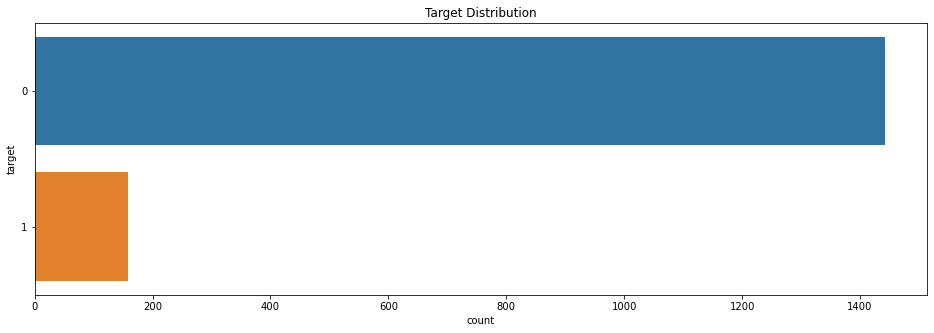

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
print(len(df_train))

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets): 
        self.image_paths = image_paths
        self.targets = targets

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)

        targets = self.targets[item]
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss.backward()
        optimizer.step()
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        loss_sum = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            loss_sum += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1))
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, loss_sum

In [26]:
baseline_name = 'efficientnet-b1' # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name: './checkpoint/efficientnet-b1-dbc7070a.pth' # Checkpoint?
}
models = []
device = "cuda"
epochs = 0
Batch_Size = 8
X = df_train.img_path.values
Y = df_train.target.values
#skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
fold = 0

train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y)
starter_models = [enetv2(baseline_name, pretrained=False, out_dim=1), enetv2(baseline_name, pretrained=True, out_dim=1)]
names = ['efficientnet-b1', 'efficientnet-b1-pretrained']
epochs = [0 for i in starter_models]
valid_losses = [[] for i in starter_models]
aurocs = [[] for i in starter_models]

print(epochs)

for model in starter_models:
    #model = enetv2(baseline_name, out_dim=1)
    model.to(device)

    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_roc_auc = 0.0
    last_roc_auc = 0.0
    roc_auc = 1.0
    row = 0
    last_loss = 0
    valid_loss = 10

    #for epoch in range(epochs):
    #while abs(last_roc_auc - roc_auc) > 0.001 or row < 2:
    #    if abs(last_roc_auc - roc_auc) < 0.001:
    while abs(last_loss - valid_loss) < 0.01 or row < 2 and epochs[fold] < 100:
        if abs(last_loss - valid_loss) < 0.01:    
            row += 1
        else:
            row = 0
        last_loss = valid_loss
        epochs[fold] += 1
        last_roc_auc = roc_auc
        train(train_loader, model, optimizer, device=device)
        predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
        
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        valid_losses[fold].append(valid_loss.detach().cpu().numpy())
        aurocs[fold].append(roc_auc)
        #f1_score = metrics.f1_score(valid_targets, predictions)
        print(f"Epoch={epochs[fold]}, Loss={valid_loss} Valid ROC AUC={roc_auc}, Distance Actual/Last={abs(roc_auc - last_roc_auc)}")

        with codecs.open('log2.log', 'a') as up:
            up.write(f"Epoch={epochs[fold]}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
        #    torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')

    torch.save(model.state_dict(), names[fold] + '-' + str(fold) + '.pt')
    models.append(model)
    fold += 1
    
print('finished')
plt.figure()
for i in range(fold):
    plt.plot(range(1, epochs[i] + 1), valid_losses[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
for i in range(fold):
    plt.plot(range(1, epochs[i] + 1), aurocs[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Valid AUC")
plt.legend()
plt.title("AUROC")
plt.show()

[0, 0]


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.32it/s]


Epoch=1, Loss=16.52924919128418 Valid ROC AUC=0.5052653033494123, Distance Actual/Last=0.49473469665058767


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.32it/s]


Epoch=2, Loss=17.049161911010742 Valid ROC AUC=0.5410353964263876, Distance Actual/Last=0.03577009307697532


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.22it/s]


Epoch=3, Loss=1180.5272216796875 Valid ROC AUC=0.5429716692710103, Distance Actual/Last=0.0019362728446226107


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.20it/s]


Epoch=4, Loss=33.002479553222656 Valid ROC AUC=0.5242203954072967, Distance Actual/Last=0.018751273863713558


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.19it/s]


Epoch=5, Loss=24.967479705810547 Valid ROC AUC=0.48124872613628644, Distance Actual/Last=0.04297166927101026


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.16it/s]


Epoch=6, Loss=30.467538833618164 Valid ROC AUC=0.46175011889394657, Distance Actual/Last=0.01949860724233987


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.17it/s]


Epoch=7, Loss=27.89859962463379 Valid ROC AUC=0.5081866974658604, Distance Actual/Last=0.046436578571913856


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.22it/s]


Epoch=8, Loss=16.52238655090332 Valid ROC AUC=0.5279230926013995, Distance Actual/Last=0.019736395135539042


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.20it/s]


Epoch=9, Loss=16.739961624145508 Valid ROC AUC=0.5601943066784428, Distance Actual/Last=0.032271214077043364


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.19it/s]


Epoch=10, Loss=19.13384437561035 Valid ROC AUC=0.5130103947279027, Distance Actual/Last=0.04718391195054017


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.14it/s]


Epoch=11, Loss=20.30659294128418 Valid ROC AUC=0.6056457639785312, Distance Actual/Last=0.09263536925062854


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.16it/s]


Epoch=12, Loss=41.64044952392578 Valid ROC AUC=0.4653509069909641, Distance Actual/Last=0.1402948569875671


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.00it/s]


Epoch=13, Loss=45.45038604736328 Valid ROC AUC=0.4423194510496637, Distance Actual/Last=0.023031455941300405


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.13it/s]


Epoch=14, Loss=26.270244598388672 Valid ROC AUC=0.532542971669271, Distance Actual/Last=0.09022352061960731


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.16it/s]


Epoch=15, Loss=16.608903884887695 Valid ROC AUC=0.5350567293973775, Distance Actual/Last=0.0025137577281064694


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.05it/s]


Epoch=16, Loss=16.35587501525879 Valid ROC AUC=0.5226577892519872, Distance Actual/Last=0.012398940145390225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.17it/s]


Epoch=17, Loss=16.674959182739258 Valid ROC AUC=0.46603030097153336, Distance Actual/Last=0.056627488280453886


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.09it/s]


Epoch=18, Loss=119.97785186767578 Valid ROC AUC=0.4995583939126299, Distance Actual/Last=0.03352809294109654


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch=19, Loss=24.004472732543945 Valid ROC AUC=0.4763910591752157, Distance Actual/Last=0.023167334737414225


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.16it/s]


Epoch=20, Loss=18.935832977294922 Valid ROC AUC=0.5107683945920238, Distance Actual/Last=0.03437733541680815


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.20it/s]


Epoch=21, Loss=16.69370460510254 Valid ROC AUC=0.5358380324750323, Distance Actual/Last=0.025069637883008422


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.76it/s]


Epoch=22, Loss=16.496896743774414 Valid ROC AUC=0.48984305999048855, Distance Actual/Last=0.045994972484543706


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.12it/s]


Epoch=23, Loss=21.606534957885742 Valid ROC AUC=0.4632787553502276, Distance Actual/Last=0.02656430464026094


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.09it/s]


Epoch=24, Loss=16.72587776184082 Valid ROC AUC=0.4195257830015626, Distance Actual/Last=0.04375297234866499


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch=25, Loss=16.821075439453125 Valid ROC AUC=0.5264623955431755, Distance Actual/Last=0.10693661254161291


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.11it/s]


Epoch=26, Loss=16.541282653808594 Valid ROC AUC=0.5639649432706026, Distance Actual/Last=0.037502547727427116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.01it/s]


Epoch=27, Loss=16.51034164428711 Valid ROC AUC=0.5172905768054895, Distance Actual/Last=0.04667436646511314


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.02it/s]


Epoch=28, Loss=17.247394561767578 Valid ROC AUC=0.5095794551260276, Distance Actual/Last=0.007711121679461863


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.74it/s]


Epoch=29, Loss=16.455596923828125 Valid ROC AUC=0.4781235138256675, Distance Actual/Last=0.03145594130036017


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.02it/s]


Epoch=30, Loss=17.32756996154785 Valid ROC AUC=0.4695971193695224, Distance Actual/Last=0.008526394456145059


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch=31, Loss=16.568038940429688 Valid ROC AUC=0.4821319383110265, Distance Actual/Last=0.0125348189415041


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.97it/s]


Epoch=32, Loss=22.9698543548584 Valid ROC AUC=0.45465045179699703, Distance Actual/Last=0.027481486514029485


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.91it/s]


Epoch=33, Loss=16.53528594970703 Valid ROC AUC=0.5015965758543379, Distance Actual/Last=0.04694612405734089


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch=34, Loss=32.660362243652344 Valid ROC AUC=0.5350567293973776, Distance Actual/Last=0.03346015354303966


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch=35, Loss=16.6602840423584 Valid ROC AUC=0.4453087845641688, Distance Actual/Last=0.0897479448332088


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.06it/s]


Epoch=36, Loss=16.538949966430664 Valid ROC AUC=0.4997961818058292, Distance Actual/Last=0.05448739724166041


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.06it/s]


Epoch=37, Loss=718.0646362304688 Valid ROC AUC=0.45927033086486857, Distance Actual/Last=0.04052585094096062


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch=38, Loss=16.640338897705078 Valid ROC AUC=0.4706162103403764, Distance Actual/Last=0.011345879475507803


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.95it/s]


Epoch=39, Loss=16.6359920501709 Valid ROC AUC=0.4987431211359467, Distance Actual/Last=0.028126910795570337


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.96it/s]


Epoch=40, Loss=20.749624252319336 Valid ROC AUC=0.46144439160269046, Distance Actual/Last=0.03729872953325625


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.02it/s]


Epoch=41, Loss=16.57987403869629 Valid ROC AUC=0.5368231537468577, Distance Actual/Last=0.07537876214416728


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.10it/s]


Epoch=42, Loss=16.73971176147461 Valid ROC AUC=0.5526190637950947, Distance Actual/Last=0.015795910048236994


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.94it/s]


Epoch=43, Loss=16.55506134033203 Valid ROC AUC=0.43851484475847546, Distance Actual/Last=0.11410421903661927


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.77it/s]


Epoch=44, Loss=16.78875732421875 Valid ROC AUC=0.4120184795162714, Distance Actual/Last=0.026496365242204056


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.86it/s]


Epoch=45, Loss=16.87812614440918 Valid ROC AUC=0.555472518513486, Distance Actual/Last=0.1434540389972146


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.07it/s]


Epoch=46, Loss=16.549341201782227 Valid ROC AUC=0.4539710578164277, Distance Actual/Last=0.10150146069705829


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch=47, Loss=16.625680923461914 Valid ROC AUC=0.4625993613696583, Distance Actual/Last=0.008628303553230576


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch=48, Loss=16.605825424194336 Valid ROC AUC=0.4915415449419118, Distance Actual/Last=0.028942183572253533


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.03it/s]


Epoch=49, Loss=16.58596420288086 Valid ROC AUC=0.47941436238874924, Distance Actual/Last=0.012127182553162585


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.95it/s]


Epoch=50, Loss=16.58966636657715 Valid ROC AUC=0.5046538487668999, Distance Actual/Last=0.025239486378150655


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.93it/s]


Epoch=51, Loss=16.533794403076172 Valid ROC AUC=0.4395339357293294, Distance Actual/Last=0.06511991303757048


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.00it/s]


Epoch=52, Loss=16.94351577758789 Valid ROC AUC=0.4912358176506556, Distance Actual/Last=0.05170188192132619


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.90it/s]


Epoch=53, Loss=24.97637176513672 Valid ROC AUC=0.5453495482030029, Distance Actual/Last=0.05411373055234725


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.06it/s]


Epoch=54, Loss=16.508445739746094 Valid ROC AUC=0.5123649704463619, Distance Actual/Last=0.03298457775664099


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.41it/s]


Epoch=55, Loss=16.7724666595459 Valid ROC AUC=0.45831917929207144, Distance Actual/Last=0.05404579115429042


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch=56, Loss=16.56751823425293 Valid ROC AUC=0.5220463346694748, Distance Actual/Last=0.06372715537740337


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.81it/s]


Epoch=57, Loss=16.53143310546875 Valid ROC AUC=0.4819960595149127, Distance Actual/Last=0.04005027515456211


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch=58, Loss=16.574108123779297 Valid ROC AUC=0.5837013384061418, Distance Actual/Last=0.1017052788912291


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.94it/s]


Epoch=59, Loss=16.63408660888672 Valid ROC AUC=0.49507439364087236, Distance Actual/Last=0.08862694476526944


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch=60, Loss=16.635480880737305 Valid ROC AUC=0.5030233032135336, Distance Actual/Last=0.007948909572661256


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.85it/s]


Epoch=61, Loss=16.52543067932129 Valid ROC AUC=0.5226577892519871, Distance Actual/Last=0.019634486038453525


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch=62, Loss=16.77878761291504 Valid ROC AUC=0.4504382091174673, Distance Actual/Last=0.07221958013451985


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch=63, Loss=16.54745101928711 Valid ROC AUC=0.5171546980093755, Distance Actual/Last=0.06671648889190823


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch=64, Loss=17.558443069458008 Valid ROC AUC=0.38120796249745226, Distance Actual/Last=0.13594673551192327


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.84it/s]


Epoch=65, Loss=16.615886688232422 Valid ROC AUC=0.44986072423398327, Distance Actual/Last=0.06865276173653101


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.07it/s]


Epoch=66, Loss=16.803146362304688 Valid ROC AUC=0.3780827501868333, Distance Actual/Last=0.07177797404714997


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch=67, Loss=16.65864372253418 Valid ROC AUC=0.47329981656362524, Distance Actual/Last=0.09521706637679195


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.66it/s]


Epoch=68, Loss=16.449275970458984 Valid ROC AUC=0.528025001698485, Distance Actual/Last=0.054725185134859744


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.91it/s]


Epoch=69, Loss=16.4930477142334 Valid ROC AUC=0.5232013044364427, Distance Actual/Last=0.004823697262042237


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.77it/s]


Epoch=70, Loss=16.4989070892334 Valid ROC AUC=0.5411712752225015, Distance Actual/Last=0.017969970786058775


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.16it/s]


Epoch=71, Loss=16.556285858154297 Valid ROC AUC=0.5259188803587201, Distance Actual/Last=0.015252394863781382


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.00it/s]


Epoch=72, Loss=16.535310745239258 Valid ROC AUC=0.45634893674842036, Distance Actual/Last=0.06956994361029978


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.59it/s]


Epoch=73, Loss=17.532970428466797 Valid ROC AUC=0.5793532169304979, Distance Actual/Last=0.12300428018207754


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.58it/s]


Epoch=74, Loss=16.702220916748047 Valid ROC AUC=0.520313880019023, Distance Actual/Last=0.05903933691147489


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch=75, Loss=16.51984214782715 Valid ROC AUC=0.5268360622324886, Distance Actual/Last=0.006522182213465566


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.84it/s]


Epoch=76, Loss=16.60335922241211 Valid ROC AUC=0.48050139275766013, Distance Actual/Last=0.04633466947482845


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.10it/s]


Epoch=77, Loss=17.205833435058594 Valid ROC AUC=0.46535090699096404, Distance Actual/Last=0.015150485766696087


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.09it/s]


Epoch=78, Loss=16.569475173950195 Valid ROC AUC=0.5603301854745567, Distance Actual/Last=0.09497927848359267


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.95it/s]


Epoch=79, Loss=16.606950759887695 Valid ROC AUC=0.5520076092125824, Distance Actual/Last=0.008322576261974302


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.93it/s]


Epoch=80, Loss=16.58454132080078 Valid ROC AUC=0.5581561247367348, Distance Actual/Last=0.006148515524152409


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.27it/s]


Epoch=81, Loss=16.59090805053711 Valid ROC AUC=0.4929343026020789, Distance Actual/Last=0.06522182213465594


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.16it/s]


Epoch=82, Loss=16.522878646850586 Valid ROC AUC=0.4636863917385692, Distance Actual/Last=0.029247910863509696


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.65it/s]


Epoch=83, Loss=16.60759925842285 Valid ROC AUC=0.5361437597662885, Distance Actual/Last=0.0724573680277193


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.05it/s]


Epoch=84, Loss=16.596424102783203 Valid ROC AUC=0.5236089408247844, Distance Actual/Last=0.0125348189415041


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.72it/s]


Epoch=85, Loss=16.500675201416016 Valid ROC AUC=0.4844418778449623, Distance Actual/Last=0.03916706297982209


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch=86, Loss=18.71959114074707 Valid ROC AUC=0.4956518785243563, Distance Actual/Last=0.011210000679394039


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.98it/s]


Epoch=87, Loss=16.811227798461914 Valid ROC AUC=0.4770025137577282, Distance Actual/Last=0.01864936476662815


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.81it/s]


Epoch=88, Loss=16.644601821899414 Valid ROC AUC=0.5255112439703785, Distance Actual/Last=0.04850873021265034


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.05it/s]


Epoch=89, Loss=16.73807716369629 Valid ROC AUC=0.46949521027243696, Distance Actual/Last=0.05601603369794156


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.03it/s]


Epoch=90, Loss=16.973669052124023 Valid ROC AUC=0.4576058156124737, Distance Actual/Last=0.011889394659963248


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.03it/s]


Epoch=91, Loss=16.62095832824707 Valid ROC AUC=0.5018003940485087, Distance Actual/Last=0.044194578436035026


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.24it/s]


Epoch=92, Loss=16.610763549804688 Valid ROC AUC=0.4433385420205177, Distance Actual/Last=0.058461852027991035


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch=93, Loss=16.70413589477539 Valid ROC AUC=0.4839323323595353, Distance Actual/Last=0.04059379033901761


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.24it/s]


Epoch=94, Loss=16.44086456298828 Valid ROC AUC=0.5043481214756437, Distance Actual/Last=0.020415789116108363


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.90it/s]


Epoch=95, Loss=16.554418563842773 Valid ROC AUC=0.5566274882804538, Distance Actual/Last=0.05227936680481016


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.40it/s]


Epoch=96, Loss=16.772775650024414 Valid ROC AUC=0.4949385148447584, Distance Actual/Last=0.061688973435695404


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.70it/s]


Epoch=97, Loss=16.5572452545166 Valid ROC AUC=0.47938039268972077, Distance Actual/Last=0.015558122155037657


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.75it/s]


Epoch=98, Loss=16.565515518188477 Valid ROC AUC=0.502615666825192, Distance Actual/Last=0.023235274135471218


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.58it/s]


Epoch=99, Loss=16.8211669921875 Valid ROC AUC=0.46929139207826615, Distance Actual/Last=0.03332427474692584


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.28it/s]


Epoch=100, Loss=16.58160400390625 Valid ROC AUC=0.5221822134655887, Distance Actual/Last=0.05289082138732254


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.68it/s]


Epoch=101, Loss=16.674638748168945 Valid ROC AUC=0.4726543922820844, Distance Actual/Last=0.049527821183504295


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.48it/s]


Epoch=102, Loss=16.562185287475586 Valid ROC AUC=0.49089612066037097, Distance Actual/Last=0.01824172837828658


Training:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 117/150 [00:32<00:09,  3.56it/s]


KeyboardInterrupt: 

103 102 102 100 97 97


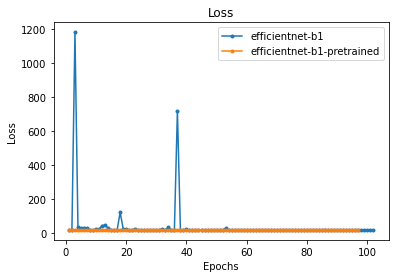

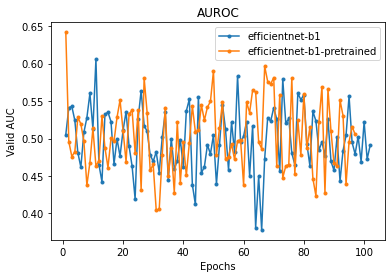

In [98]:
print(epochs[0], len(valid_losses[0]), len(aurocs[0]), epochs[1], len(valid_losses[1]), len(aurocs[1]))
epochs2 = [103, 98]
valid_losses2 = copy.deepcopy(valid_losses)
#print(valid_losses2[0][36])
#valid_losses2[0][2] = 17
#valid_losses2[0][36] = 17
#valid_losses2[0][17] = 17
#print(valid_losses2[0][17])
plt.figure()
for i in range(fold):
    plt.plot(range(1, epochs2[i]), valid_losses2[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
for i in range(fold):
    plt.plot(range(1, epochs2[i]), aurocs[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Valid AUC")
plt.legend()
plt.title("AUROC")
plt.show()

In [53]:
for model in starter_models:
    if model == names[0]:
        fold += 1
        continue
    #model = enetv2(baseline_name, out_dim=1)
    model.to(device)

    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_roc_auc = 0.0
    last_roc_auc = 0.0
    roc_auc = 1.0
    row = 0
    last_loss = 0
    valid_loss = 10

    #for epoch in range(epochs):
    #while abs(last_roc_auc - roc_auc) > 0.001 or row < 2:
    #    if abs(last_roc_auc - roc_auc) < 0.001:
    while abs(last_loss - valid_loss) < 0.01 or row < 2 and epochs[fold] < 100:
        if abs(last_loss - valid_loss) < 0.01:    
            row += 1
        else:
            row = 0
        last_loss = valid_loss
        epochs[fold] += 1
        last_roc_auc = roc_auc
        train(train_loader, model, optimizer, device=device)
        predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
        
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        valid_losses[fold].append(valid_loss.detach().cpu().numpy())
        aurocs[fold].append(roc_auc)
        #f1_score = metrics.f1_score(valid_targets, predictions)
        print(f"Epoch={epochs[fold]}, Loss={valid_loss} Valid ROC AUC={roc_auc}, Distance Actual/Last={abs(roc_auc - last_roc_auc)}")

        with codecs.open('log2.log', 'a') as up:
            up.write(f"Epoch={epochs[fold]}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
        #    torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')

    torch.save(model.state_dict(), names[fold] + '-' + str(fold) + '.pt')
    models.append(model)
    #fold += 1

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.47it/s]


Epoch=67, Loss=16.51784896850586 Valid ROC AUC=0.5623004280182077, Distance Actual/Last=0.4376995719817923


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.61it/s]


Epoch=68, Loss=16.671419143676758 Valid ROC AUC=0.4951423330389293, Distance Actual/Last=0.06715809497927838


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.53it/s]


Epoch=69, Loss=16.73189926147461 Valid ROC AUC=0.4865479991847272, Distance Actual/Last=0.008594333854202107


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.04it/s]


Epoch=70, Loss=16.432628631591797 Valid ROC AUC=0.5966098240369591, Distance Actual/Last=0.11006182485223187


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.76it/s]


Epoch=71, Loss=16.43243980407715 Valid ROC AUC=0.5759562470276514, Distance Actual/Last=0.0206535770093077


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.68it/s]


Epoch=72, Loss=16.666513442993164 Valid ROC AUC=0.572797065018004, Distance Actual/Last=0.0031591820096473766


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.82it/s]


Epoch=73, Loss=16.75391960144043 Valid ROC AUC=0.5814933079692913, Distance Actual/Last=0.008696242951287347


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.04it/s]


Epoch=74, Loss=16.602060317993164 Valid ROC AUC=0.46344860384537, Distance Actual/Last=0.11804470412392132


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.25it/s]


Epoch=75, Loss=16.468769073486328 Valid ROC AUC=0.5586996399211903, Distance Actual/Last=0.0952510360758203


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.21it/s]


Epoch=76, Loss=16.60729217529297 Valid ROC AUC=0.44778857259324684, Distance Actual/Last=0.11091106732794348


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch=77, Loss=16.565776824951172 Valid ROC AUC=0.46341463414634143, Distance Actual/Last=0.015626061553094595


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.95it/s]


Epoch=78, Loss=16.901844024658203 Valid ROC AUC=0.4653848766899925, Distance Actual/Last=0.0019702425436510795


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.13it/s]


Epoch=79, Loss=16.607318878173828 Valid ROC AUC=0.5803383382023236, Distance Actual/Last=0.1149534615123311


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch=80, Loss=16.555057525634766 Valid ROC AUC=0.45268020925334596, Distance Actual/Last=0.12765812894897766


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.14it/s]


Epoch=81, Loss=16.530744552612305 Valid ROC AUC=0.5246280317956383, Distance Actual/Last=0.07194782254229237


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.62it/s]


Epoch=82, Loss=16.54494285583496 Valid ROC AUC=0.478157483524696, Distance Actual/Last=0.046470548270942325


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.82it/s]


Epoch=83, Loss=16.5289249420166 Valid ROC AUC=0.5593450642027311, Distance Actual/Last=0.08118758067803511


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.67it/s]


Epoch=84, Loss=16.526498794555664 Valid ROC AUC=0.4868537264759834, Distance Actual/Last=0.0724913377267477


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch=85, Loss=16.629798889160156 Valid ROC AUC=0.5152523948637815, Distance Actual/Last=0.028398668387798087


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.67it/s]


Epoch=86, Loss=16.619680404663086 Valid ROC AUC=0.44663360282627895, Distance Actual/Last=0.06861879203750254


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.75it/s]


Epoch=87, Loss=16.64480209350586 Valid ROC AUC=0.42363611658400707, Distance Actual/Last=0.02299748624227188


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.77it/s]


Epoch=88, Loss=16.545915603637695 Valid ROC AUC=0.5219104558733609, Distance Actual/Last=0.09827433928935386


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.76it/s]


Epoch=89, Loss=16.515531539916992 Valid ROC AUC=0.5688226102316732, Distance Actual/Last=0.04691215435831231


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.79it/s]


Epoch=90, Loss=16.625459671020508 Valid ROC AUC=0.4278483592635369, Distance Actual/Last=0.14097425096813632


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.67it/s]


Epoch=91, Loss=16.665002822875977 Valid ROC AUC=0.565595488823969, Distance Actual/Last=0.1377471295604321


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.84it/s]


Epoch=92, Loss=16.578685760498047 Valid ROC AUC=0.5098851824172839, Distance Actual/Last=0.05571030640668517


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.18it/s]


Epoch=93, Loss=16.611148834228516 Valid ROC AUC=0.4670154222433589, Distance Actual/Last=0.042869760173924965


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.79it/s]


Epoch=94, Loss=16.499711990356445 Valid ROC AUC=0.46334669474828455, Distance Actual/Last=0.003668727495074353


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.69it/s]


Epoch=95, Loss=16.469749450683594 Valid ROC AUC=0.5511923364358993, Distance Actual/Last=0.08784564168761472


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.52it/s]


Epoch=96, Loss=16.639102935791016 Valid ROC AUC=0.5305387594265913, Distance Actual/Last=0.020653577009307922


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.76it/s]


Epoch=97, Loss=16.60573387145996 Valid ROC AUC=0.4392282084380732, Distance Actual/Last=0.09131055098851815


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.90it/s]


Epoch=98, Loss=16.58595085144043 Valid ROC AUC=0.49568584822338474, Distance Actual/Last=0.05645763978531154


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.06it/s]


Epoch=99, Loss=16.534717559814453 Valid ROC AUC=0.5159997282424078, Distance Actual/Last=0.020313880019023067


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.76it/s]


Epoch=100, Loss=16.719505310058594 Valid ROC AUC=0.5058088185338678, Distance Actual/Last=0.010190909708539975


In [61]:
fold = 2

In [90]:
import copy
